In [1]:
import pandas as pd

# 5. Calcular el radio de impacto del sismo (ejemplo)
magnitud_momento = 9
profundidad = 33 

def calcular_radio_impacto(magnitud_momento, profundidad):
    # Factores de ajuste
    factor_profundidad = 10 / (profundidad + 10)
    factor_magnitud = 10 ** (0.5 * magnitud_momento - 0.6)
    
    # Ajuste no lineal para magnitudes extremas
    if magnitud_momento < 5:
        factor_magnitud *= 1.2  
    elif magnitud_momento > 8:
        factor_magnitud *= 0.6
    
    r_km = factor_magnitud * factor_profundidad
    
    return r_km

R_km = calcular_radio_impacto(magnitud_momento, profundidad)

print(R_km)


1108.3649786850438


In [2]:

import numpy as np
import geopandas as gpd
from shapely.geometry import shape, Point
from geopy.distance import geodesic

# 1. Cargar el archivo CSV
df = pd.read_csv('poblacion.csv', sep=';')

# 2. Crear una función para convertir GeoJSON a geometría Shapely
def convert_geojson_to_geometry(geojson_string):
    return shape(eval(geojson_string))

# 3. Aplicar la función para convertir GeoJSON a geometrías Shapely y crear un GeoDataFrame
df['geometry'] = df['Geo Shape'].apply(convert_geojson_to_geometry)
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# 4. Definir el epicentro del sismo (ejemplo)
epicentro_lat = -12.04318
epicentro_lon = -77.02824

epicentro = Point(epicentro_lon, epicentro_lat)


# Convertir el radio de km a grados de longitud y latitud
R_deg_lon = R_km / (111.32 * np.cos(np.radians(epicentro_lat)))  # Longitud
R_deg_lat = R_km / 110.574  # Latitud

# 6. Crear un buffer circular alrededor del epicentro del sismo
area_de_efecto = epicentro.buffer(R_deg_lon)

# 7. Intersectar el área de efecto con los distritos en el GeoDataFrame
distritos_en_area_efecto = gdf[gdf['geometry'].intersects(area_de_efecto)]

# 8. Calcular la distancia geodésica desde el epicentro a cada distrito afectado
def calcular_distancia(geometry, epicentro):
    centroide_distrito = geometry.centroid
    distancia = geodesic((epicentro.y, epicentro.x), (centroide_distrito.y, centroide_distrito.x)).kilometers
    return distancia

distritos_en_area_efecto['DISTANCIA'] = distritos_en_area_efecto['geometry'].apply(lambda geom: calcular_distancia(geom, epicentro))

/home/leon/Documentos/UNSA/IA/articulo-ia/venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


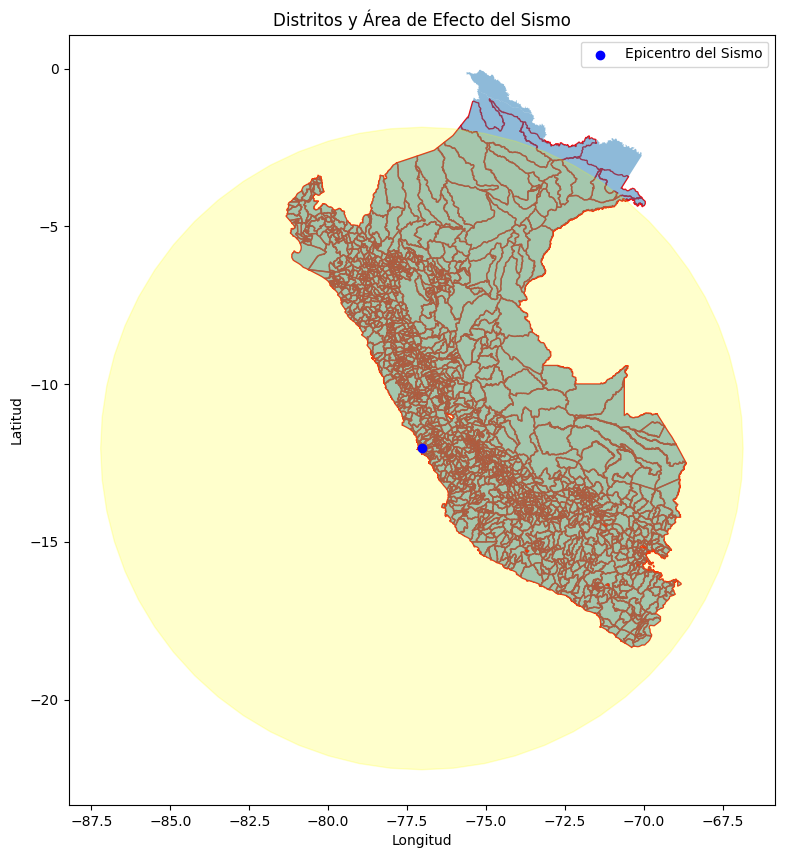

   NOMBDIST   NOMBPROV     NOMBDEP   DISTANCIA  POBLACION
0  GUZMANGO  CONTUMAZA   CAJAMARCA  557.481412     2864.0
1  SAN LUIS  SAN PABLO   CAJAMARCA  576.900029      949.0
2   LAGUNAS   CHICLAYO  LAMBAYEQUE  627.310880    10899.0
3   MONSEFU   CHICLAYO  LAMBAYEQUE  651.454555    35368.0
4   CAYALTI   CHICLAYO  LAMBAYEQUE  631.702049    16364.0


In [3]:

# 9. Visualizar el resultado
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

# Plotear los distritos que intersectan con el área de efecto
distritos_en_area_efecto.plot(ax=ax, edgecolor='red', facecolor='none')

# Plotear todos los distritos en transparencia
gdf.plot(ax=ax, alpha=0.5)

# Plotear el área de efecto del sismo
x, y = area_de_efecto.exterior.xy
ax.fill(x, y, alpha=0.2, color='yellow')

# Plotear el epicentro del sismo
ax.scatter(epicentro_lon, epicentro_lat, color='blue', label='Epicentro del Sismo', zorder=5)

# Configuración adicional del gráfico
ax.set_title('Distritos y Área de Efecto del Sismo')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.legend()

# Guardar la figura como archivo PNG
plt.savefig('distritos_area_efecto_sismo.png', dpi=300)

# Mostrar el gráfico
plt.show()

# Mostrar las primeras filas para verificar
print(distritos_en_area_efecto[['NOMBDIST', 'NOMBPROV', 'NOMBDEP', 'DISTANCIA', 'POBLACION']].head())

In [4]:
distritos_en_area_efecto.columns

Index(['Geo Point', 'Geo Shape', 'CCDD', 'NOMBDEP', 'CCPP', 'NOMBPROV', 'CCDI',
       'NOMBDIST', 'CAPITAL', 'UBIGEO', 'IDPROV', 'CODIGO', 'CNT_CCPP',
       'DESCRIPCIO', 'POBLACION', 'FECHA', 'DAT_POB', 'geometry', 'DISTANCIA'],
      dtype='object')

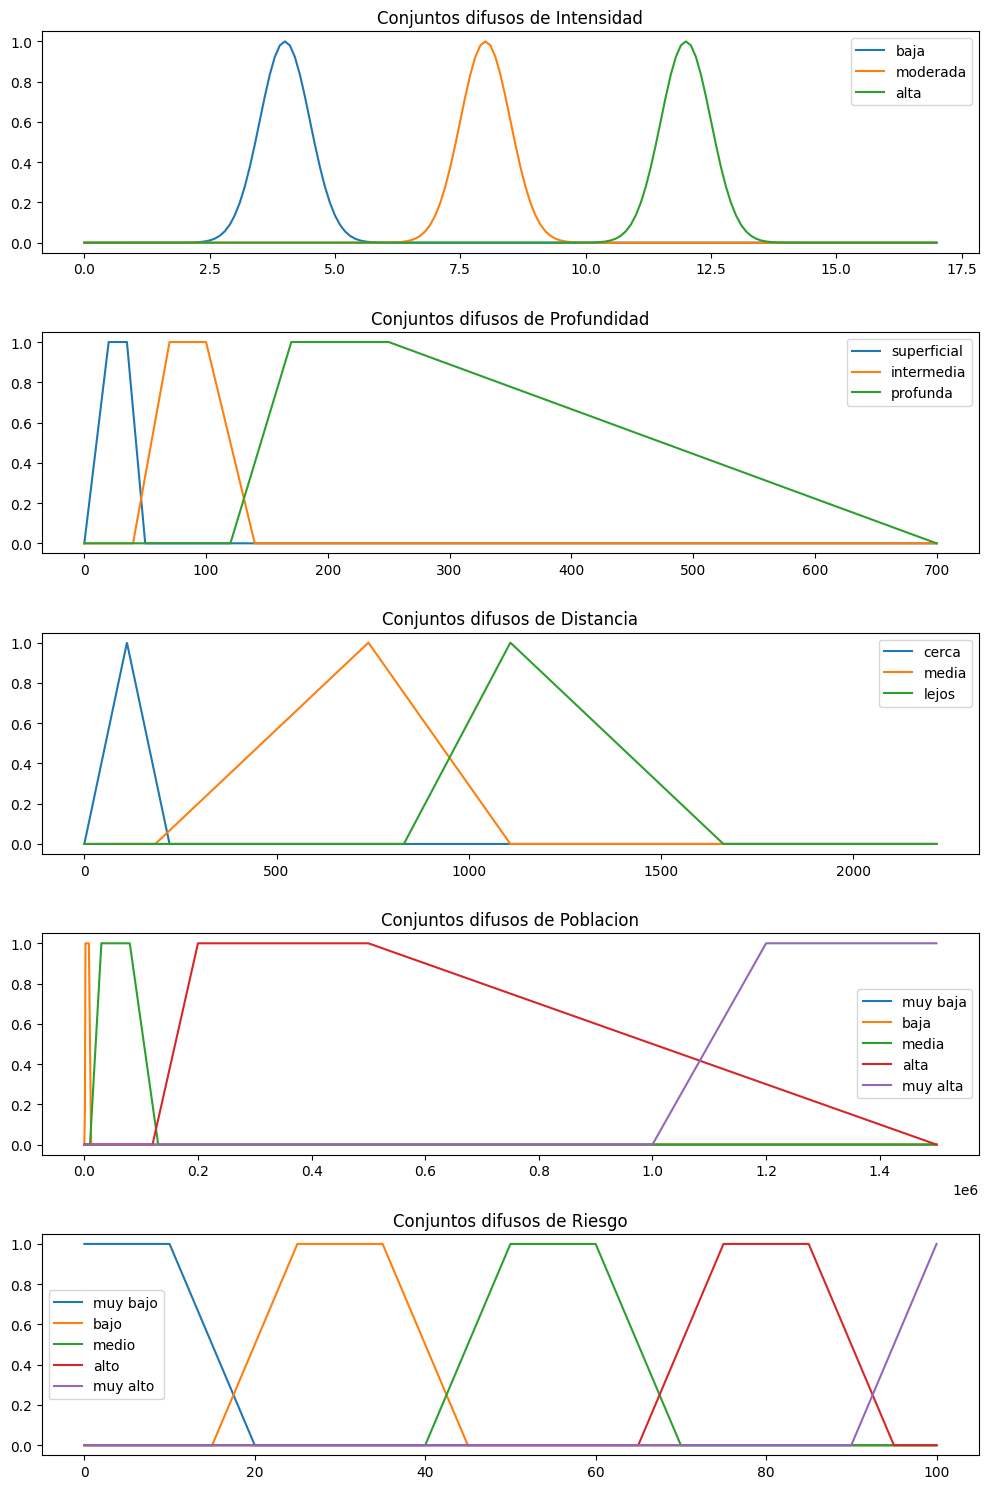

In [90]:
# Graficar los conjuntos difusos
variables = [intensidad, profundidad, distancia ,poblacion, riesgo]
nombres = ['Intensidad', 'Profundidad','Distancia', 'Poblacion', 'Riesgo']

fig, axs = plt.subplots(len(variables), figsize=(10, 15))

for i, (variable, nombre) in enumerate(zip(variables, nombres)):
    for conjunto in variable.terms:
        axs[i].plot(variable.universe, variable[conjunto].mf, label=conjunto)
    axs[i].set_title(f'Conjuntos difusos de {nombre}')
    axs[i].legend()

plt.tight_layout()
plt.show()

In [91]:
combinaciones = [
    # Intensidad baja
    ('baja', 'superficial', 'muy baja', 'cerca', 'muy bajo'),
    ('baja', 'superficial', 'baja', 'cerca', 'bajo'),
    ('baja', 'superficial', 'media', 'cerca', 'bajo'),
    ('baja', 'superficial', 'alta', 'cerca', 'bajo'),
    ('baja', 'superficial', 'muy alta', 'cerca', 'bajo'),
    ('baja', 'superficial', 'muy baja', 'media', 'bajo'),
    ('baja', 'superficial', 'baja', 'media', 'bajo'),
    ('baja', 'superficial', 'media', 'media', 'bajo'),
    ('baja', 'superficial', 'alta', 'media', 'bajo'),
    ('baja', 'superficial', 'muy alta', 'media', 'bajo'),
    ('baja', 'superficial', 'muy baja', 'lejos', 'bajo'),
    ('baja', 'superficial', 'baja', 'lejos', 'bajo'),
    ('baja', 'superficial', 'media', 'lejos', 'bajo'),
    ('baja', 'superficial', 'alta', 'lejos', 'bajo'),
    ('baja', 'superficial', 'muy alta', 'lejos', 'bajo'),
    
    ('baja', 'intermedia', 'muy baja', 'cerca', 'bajo'),
    ('baja', 'intermedia', 'baja', 'cerca', 'bajo'),
    ('baja', 'intermedia', 'media', 'cerca', 'bajo'),
    ('baja', 'intermedia', 'alta', 'cerca', 'bajo'),
    ('baja', 'intermedia', 'muy alta', 'cerca', 'bajo'),
    ('baja', 'intermedia', 'muy baja', 'media', 'bajo'),
    ('baja', 'intermedia', 'baja', 'media', 'bajo'),
    ('baja', 'intermedia', 'media', 'media', 'bajo'),
    ('baja', 'intermedia', 'alta', 'media', 'bajo'),
    ('baja', 'intermedia', 'muy alta', 'media', 'bajo'),
    ('baja', 'intermedia', 'muy baja', 'lejos', 'bajo'),
    ('baja', 'intermedia', 'baja', 'lejos', 'bajo'),
    ('baja', 'intermedia', 'media', 'lejos', 'bajo'),
    ('baja', 'intermedia', 'alta', 'lejos', 'bajo'),
    ('baja', 'intermedia', 'muy alta', 'lejos', 'bajo'),
    
    ('baja', 'profunda', 'muy baja', 'cerca', 'bajo'),
    ('baja', 'profunda', 'baja', 'cerca', 'bajo'),
    ('baja', 'profunda', 'media', 'cerca', 'bajo'),
    ('baja', 'profunda', 'alta', 'cerca', 'bajo'),
    ('baja', 'profunda', 'muy alta', 'cerca', 'bajo'),
    ('baja', 'profunda', 'muy baja', 'media', 'bajo'),
    ('baja', 'profunda', 'baja', 'media', 'bajo'),
    ('baja', 'profunda', 'media', 'media', 'bajo'),
    ('baja', 'profunda', 'alta', 'media', 'bajo'),
    ('baja', 'profunda', 'muy alta', 'media', 'bajo'),
    ('baja', 'profunda', 'muy baja', 'lejos', 'bajo'),
    ('baja', 'profunda', 'baja', 'lejos', 'bajo'),
    ('baja', 'profunda', 'media', 'lejos', 'bajo'),
    ('baja', 'profunda', 'alta', 'lejos', 'bajo'),
    ('baja', 'profunda', 'muy alta', 'lejos', 'bajo'),
    
    # Intensidad moderada
    ('moderada', 'superficial', 'muy baja', 'cerca', 'bajo'),
    ('moderada', 'superficial', 'baja', 'cerca', 'bajo'),
    ('moderada', 'superficial', 'media', 'cerca', 'medio'),
    ('moderada', 'superficial', 'alta', 'cerca', 'medio'),
    ('moderada', 'superficial', 'muy alta', 'cerca', 'medio'),
    ('moderada', 'superficial', 'muy baja', 'media', 'bajo'),
    ('moderada', 'superficial', 'baja', 'media', 'bajo'),
    ('moderada', 'superficial', 'media', 'media', 'medio'),
    ('moderada', 'superficial', 'alta', 'media', 'medio'),
    ('moderada', 'superficial', 'muy alta', 'media', 'medio'),
    ('moderada', 'superficial', 'muy baja', 'lejos', 'bajo'),
    ('moderada', 'superficial', 'baja', 'lejos', 'bajo'),
    ('moderada', 'superficial', 'media', 'lejos', 'medio'),
    ('moderada', 'superficial', 'alta', 'lejos', 'medio'),
    ('moderada', 'superficial', 'muy alta', 'lejos', 'medio'),
    
    ('moderada', 'intermedia', 'muy baja', 'cerca', 'bajo'),
    ('moderada', 'intermedia', 'baja', 'cerca', 'bajo'),
    ('moderada', 'intermedia', 'media', 'cerca', 'medio'),
    ('moderada', 'intermedia', 'alta', 'cerca', 'medio'),
    ('moderada', 'intermedia', 'muy alta', 'cerca', 'medio'),
    ('moderada', 'intermedia', 'muy baja', 'media', 'bajo'),
    ('moderada', 'intermedia', 'baja', 'media', 'bajo'),
    ('moderada', 'intermedia', 'media', 'media', 'medio'),
    ('moderada', 'intermedia', 'alta', 'media', 'medio'),
    ('moderada', 'intermedia', 'muy alta', 'media', 'medio'),
    ('moderada', 'intermedia', 'muy baja', 'lejos', 'bajo'),
    ('moderada', 'intermedia', 'baja', 'lejos', 'bajo'),
    ('moderada', 'intermedia', 'media', 'lejos', 'medio'),
    ('moderada', 'intermedia', 'alta', 'lejos', 'medio'),
    ('moderada', 'intermedia', 'muy alta', 'lejos', 'medio'),
    
    ('moderada', 'profunda', 'muy baja', 'cerca', 'bajo'),
    ('moderada', 'profunda', 'baja', 'cerca', 'bajo'),
    ('moderada', 'profunda', 'media', 'cerca', 'medio'),
    ('moderada', 'profunda', 'alta', 'cerca', 'medio'),
    ('moderada', 'profunda', 'muy alta', 'cerca', 'medio'),
    ('moderada', 'profunda', 'muy baja', 'media', 'bajo'),
    ('moderada', 'profunda', 'baja', 'media', 'bajo'),
    ('moderada', 'profunda', 'media', 'media', 'medio'),
    ('moderada', 'profunda', 'alta', 'media', 'medio'),
    ('moderada', 'profunda', 'muy alta', 'media', 'medio'),
    ('moderada', 'profunda', 'muy baja', 'lejos', 'bajo'),
    ('moderada', 'profunda', 'baja', 'lejos', 'bajo'),
    ('moderada', 'profunda', 'media', 'lejos', 'medio'),
    ('moderada', 'profunda', 'alta', 'lejos', 'medio'),
    ('moderada', 'profunda', 'muy alta', 'lejos', 'medio'),
    
    # Intensidad alta
    ('alta', 'superficial', 'muy baja', 'cerca', 'medio'),
    ('alta', 'superficial', 'baja', 'cerca', 'medio'),
    ('alta', 'superficial', 'media', 'cerca', 'alto'),
    ('alta', 'superficial', 'alta', 'cerca', 'alto'),
    ('alta', 'superficial', 'muy alta', 'cerca', 'alto'),
    ('alta', 'superficial', 'muy baja', 'media', 'medio'),
    ('alta', 'superficial', 'baja', 'media', 'medio'),
    ('alta', 'superficial', 'media', 'media', 'alto'),
    ('alta', 'superficial', 'alta', 'media', 'alto'),
    ('alta', 'superficial', 'muy alta', 'media', 'alto'),
    ('alta', 'superficial', 'muy baja', 'lejos', 'medio'),
    ('alta', 'superficial', 'baja', 'lejos', 'medio'),
    ('alta', 'superficial', 'media', 'lejos', 'alto'),
    ('alta', 'superficial', 'alta', 'lejos', 'alto'),
    ('alta', 'superficial', 'muy alta', 'lejos', 'alto'),
    
    ('alta', 'intermedia', 'muy baja', 'cerca', 'medio'),
    ('alta', 'intermedia', 'baja', 'cerca', 'medio'),
    ('alta', 'intermedia', 'media', 'cerca', 'alto'),
    ('alta', 'intermedia', 'alta', 'cerca', 'alto'),
    ('alta', 'intermedia', 'muy alta', 'cerca', 'alto'),
    ('alta', 'intermedia', 'muy baja', 'media', 'medio'),
    ('alta', 'intermedia', 'baja', 'media', 'medio'),
    ('alta', 'intermedia', 'media', 'media', 'alto'),
    ('alta', 'intermedia', 'alta', 'media', 'alto'),
    ('alta', 'intermedia', 'muy alta', 'media', 'alto'),
    ('alta', 'intermedia', 'muy baja', 'lejos', 'medio'),
    ('alta', 'intermedia', 'baja', 'lejos', 'medio'),
    ('alta', 'intermedia', 'media', 'lejos', 'alto'),
    ('alta', 'intermedia', 'alta', 'lejos', 'alto'),
    ('alta', 'intermedia', 'muy alta', 'lejos', 'alto'),
    
    ('alta', 'profunda', 'muy baja', 'cerca', 'medio'),
    ('alta', 'profunda', 'baja', 'cerca', 'medio'),
    ('alta', 'profunda', 'media', 'cerca', 'alto'),
    ('alta', 'profunda', 'alta', 'cerca', 'alto'),
    ('alta', 'profunda', 'muy alta', 'cerca', 'alto'),
    ('alta', 'profunda', 'muy baja', 'media', 'medio'),
    ('alta', 'profunda', 'baja', 'media', 'medio'),
    ('alta', 'profunda', 'media', 'media', 'alto'),
    ('alta', 'profunda', 'alta', 'media', 'alto'),
    ('alta', 'profunda', 'muy alta', 'media', 'alto'),
    ('alta', 'profunda', 'muy baja', 'lejos', 'medio'),
    ('alta', 'profunda', 'baja', 'lejos', 'medio'),
    ('alta', 'profunda', 'media', 'lejos', 'alto'),
    ('alta', 'profunda', 'alta', 'lejos', 'alto'),
    ('alta', 'profunda', 'muy alta', 'lejos', 'alto')
]
# Crear las reglas basadas en las combinaciones
reglas = []
for comb in combinaciones:
    i, p, po, d, r = comb
    regla = ctrl.Rule(intensidad[i] & profundidad[p] & poblacion[po] & distancia[d], riesgo[r])
    reglas.append(regla)

# Crear el sistema de control difuso
control_riesgo = ctrl.ControlSystem(reglas)
simulacion_riesgo = ctrl.ControlSystemSimulation(control_riesgo)


In [92]:
def calcular_intensidad(distancia, magnitud):
    return 1.7*magnitud -4.82*np.log10(distancia) + 3.97

# Supongamos que la magnitud del terremoto está almacenada en una variable 'magnitud'

# Aplicar la fórmula a cada fila de la columna 'Distancia al Epicentro (km)', pasando la magnitud como un argumento adicional
distritos_en_area_efecto['INTENSIDAD'] = distritos_en_area_efecto['DISTANCIA'].apply(lambda x: calcular_intensidad(x, magnitud_momento))

In [93]:

# Inicializar una lista para almacenar los resultados de riesgo
resultados_riesgo = []
# Iterar sobre cada fila del DataFrame y calcular el riesgo
for index, row in distritos_en_area_efecto.iterrows():
    simulacion_riesgo.input['intensidad'] = row['INTENSIDAD']  # Puedes ajustar estos valores según tu caso
    simulacion_riesgo.input['profundidad'] = 33  # Puedes ajustar estos valores según tu caso
    simulacion_riesgo.input['distancia'] = row['DISTANCIA']
    simulacion_riesgo.input['poblacion'] = row['POBLACION']
    
    # Computar el resultado
    simulacion_riesgo.compute()
    
    # Obtener el resultado
    resultado_riesgo = simulacion_riesgo.output['riesgo']
    
    # Agregar el resultado a la lista
    resultados_riesgo.append(resultado_riesgo)

# Agregar los resultados al DataFrame original
distritos_en_area_efecto['RIESGO'] = resultados_riesgo


In [94]:

# Mostrar el DataFrame con los resultados de riesgo
distritos_en_area_efecto[['NOMBDIST' , 'NOMBPROV' ,'POBLACION','RIESGO', 'DISTANCIA' , 'INTENSIDAD']].head()

,NOMBDIST,NOMBPROV,POBLACION,RIESGO,DISTANCIA,INTENSIDAD
0,GUZMANGO,CONTUMAZA,2864.0,30.000000,557.481412,6.033170
1,SAN LUIS,SAN PABLO,949.0,30.000000,576.900029,5.961495
2,LAGUNAS,CHICLAYO,10899.0,30.732143,627.310880,5.786133
3,MONSEFU,CHICLAYO,35368.0,30.214371,651.454555,5.707079
4,CAYALTI,CHICLAYO,16364.0,30.590025,631.702049,5.771531


In [87]:
distritos_csv = distritos_en_area_efecto[['NOMBDIST' , 'NOMBPROV' , 'NOMBDEP', 'POBLACION' , 'INTENSIDAD' , 'DISTANCIA' ,'RIESGO']]
distritos_csv.to_csv('riesgo.csv')

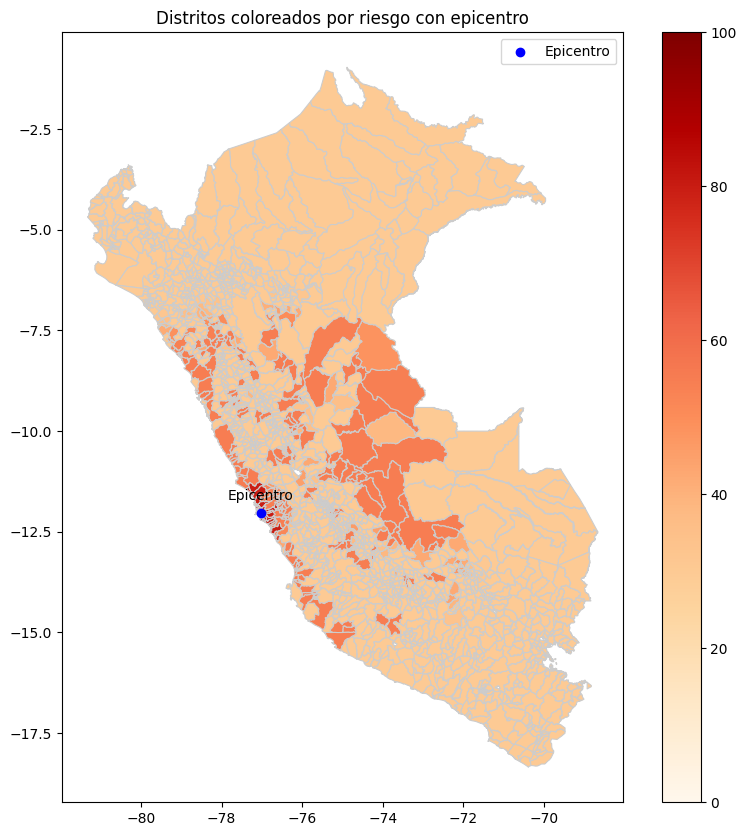

In [88]:
import geopandas as gpd
from matplotlib.colors import Normalize
distritos_en_area_efecto['geometry'] = distritos_en_area_efecto['Geo Shape'].apply(convert_geojson_to_geometry)

gdf = gpd.GeoDataFrame(distritos_en_area_efecto, geometry='geometry')

# Configurar la escala de color con un límite máximo de 100
norm = Normalize(vmin=0, vmax=100)

# Graficar los distritos y colorearlos según el riesgo
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(column='RIESGO', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, norm=norm)

# Graficar el epicentro
ax.scatter(epicentro_lon, epicentro_lat, color='blue', label='Epicentro', zorder=5)
ax.annotate('Epicentro', (epicentro_lon, epicentro_lat), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Distritos coloreados por riesgo con epicentro')
plt.legend()
plt.show()